In [1]:
from explainability_module import ExplainabilityModule
from dataset_manager.movie_lens_manager import MovieLensManager, ROOT

In [2]:
VANILLA_ROOT = f"{ROOT}/llm/vanilla"
GRAPH_PROMPTER_HF_FROZEN_ROOT = f"{ROOT}/llm/graph_prompter_hf_frozen"
GRAPH_PROMPTER_HF_ROOT = f"{ROOT}/llm/graph_prompter_hf"

In [3]:
kg_manager = MovieLensManager()
dataset_vanilla, _ = kg_manager.shard_dataset_randomly(
    VANILLA_ROOT,
    GRAPH_PROMPTER_HF_FROZEN_ROOT,
    GRAPH_PROMPTER_HF_ROOT,
    shard_size=100000,
)
exp = ExplainabilityModule(kg_manager.load_xai_artifact, dataset_vanilla)

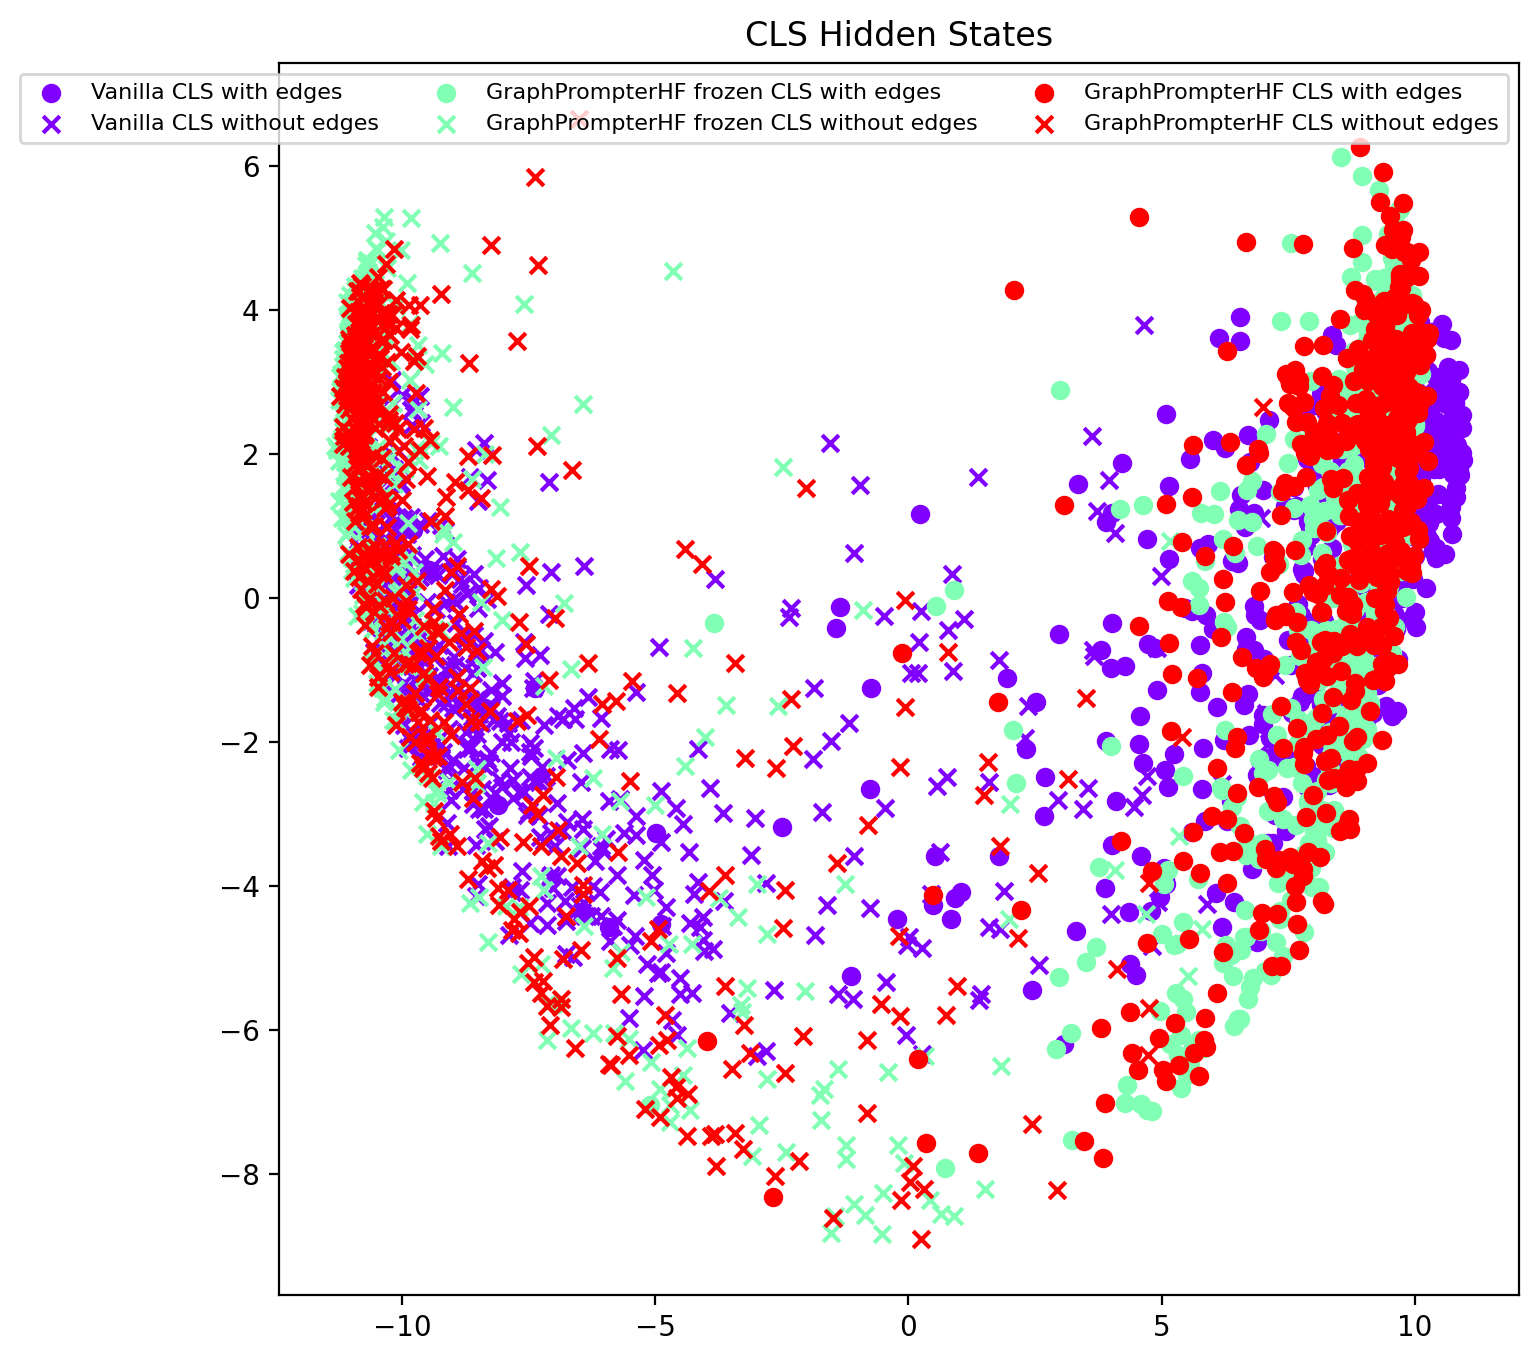

<Figure size 1600x1600 with 0 Axes>

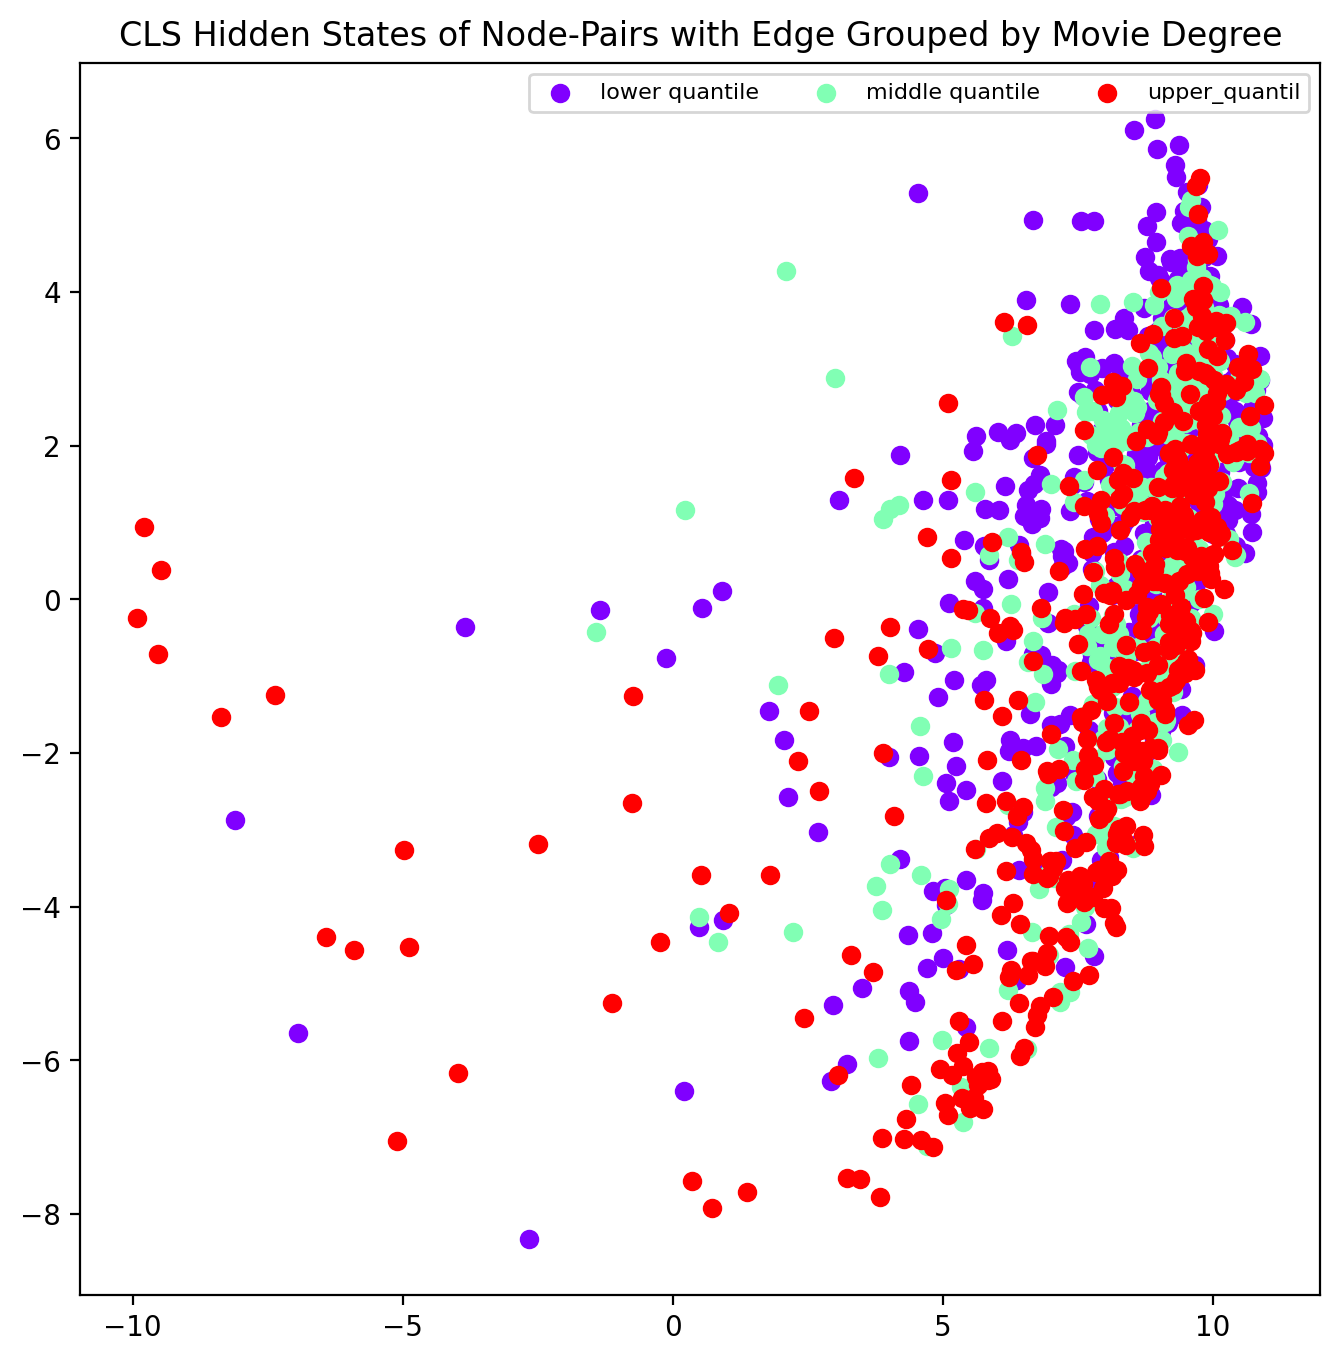

<Figure size 1600x1600 with 0 Axes>

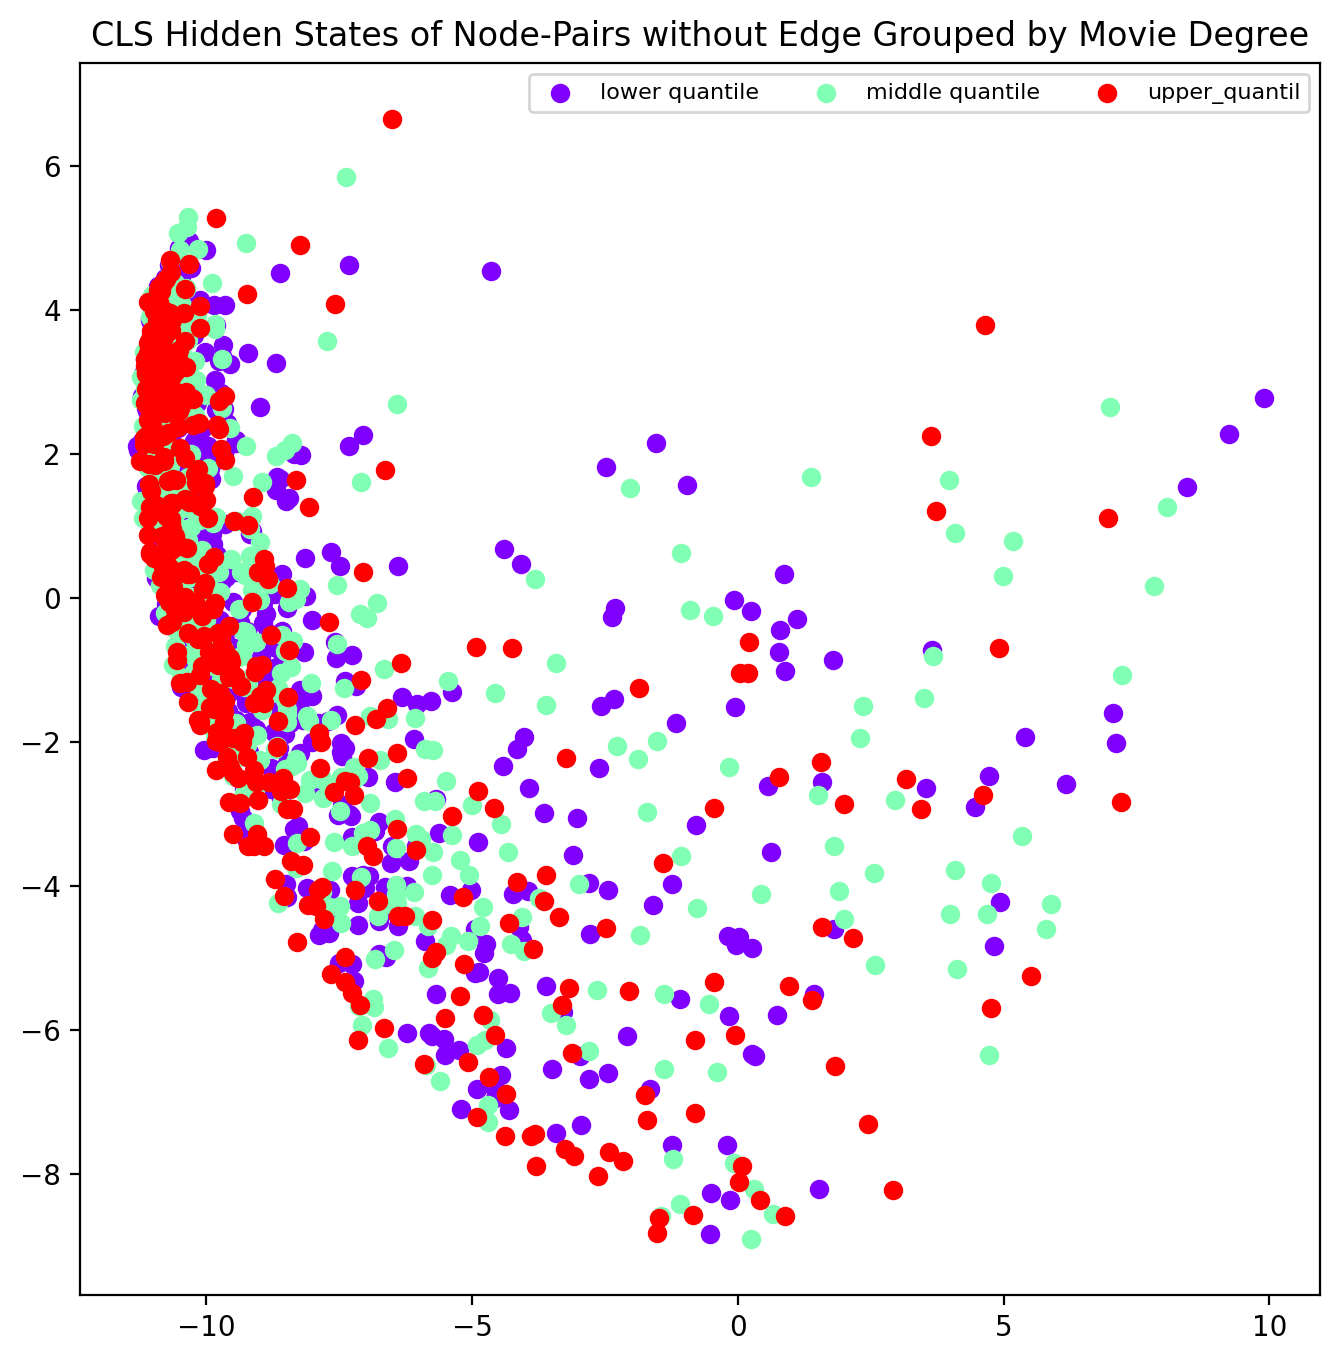

<Figure size 1600x1600 with 0 Axes>

In [4]:
exp.plot_cls_embeddings(samples=1000)

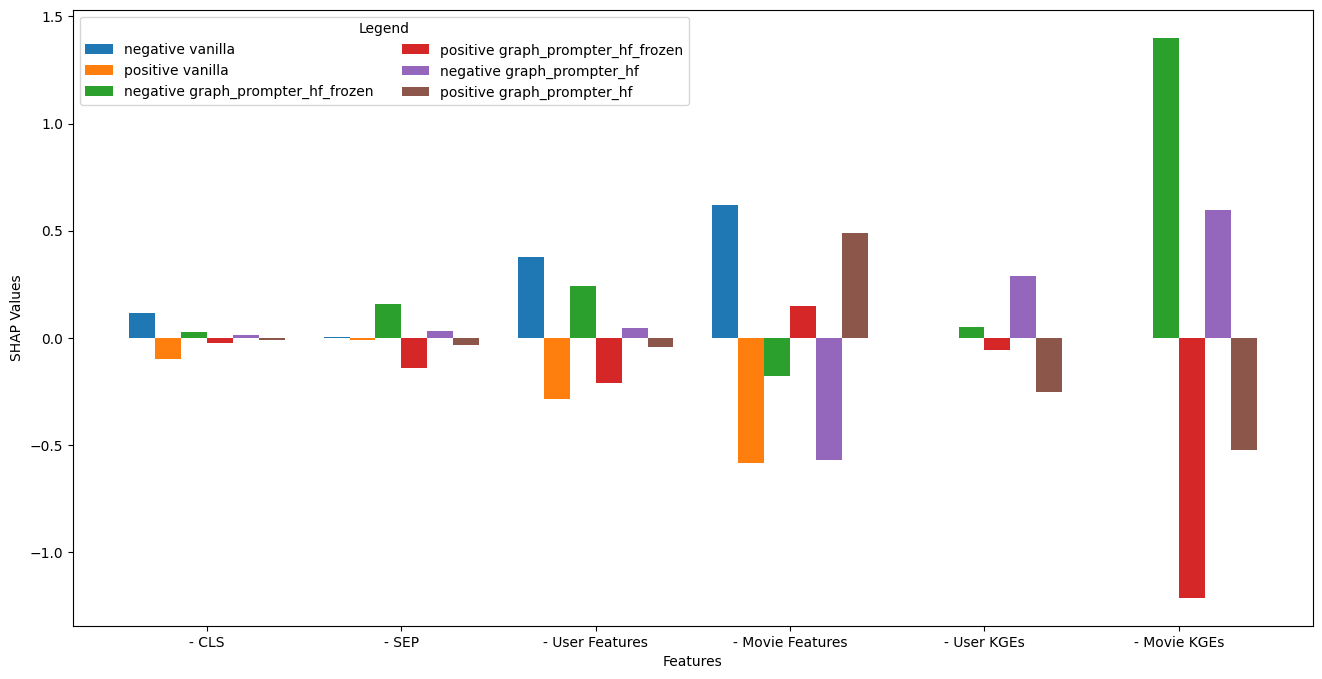

In [ ]:
exp.plot_shap_values()

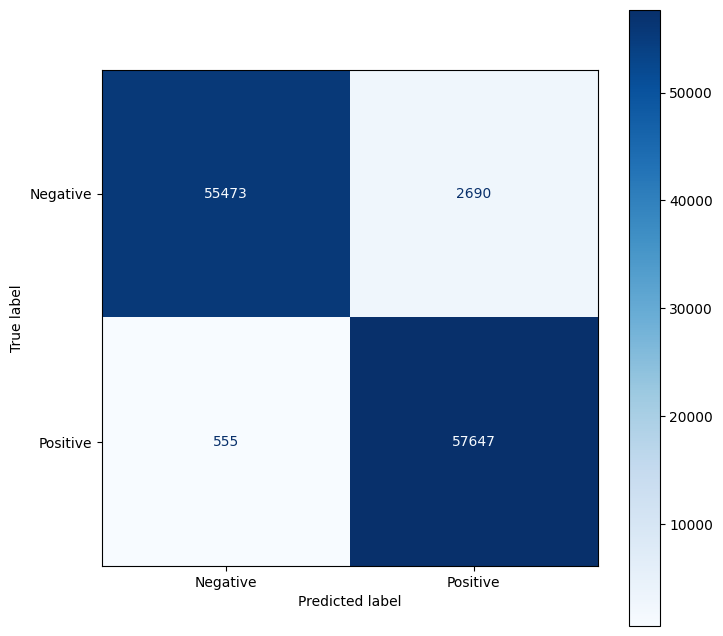

In [ ]:
exp.plot_confusion_map("test", [0], "graph_prompter_hf")

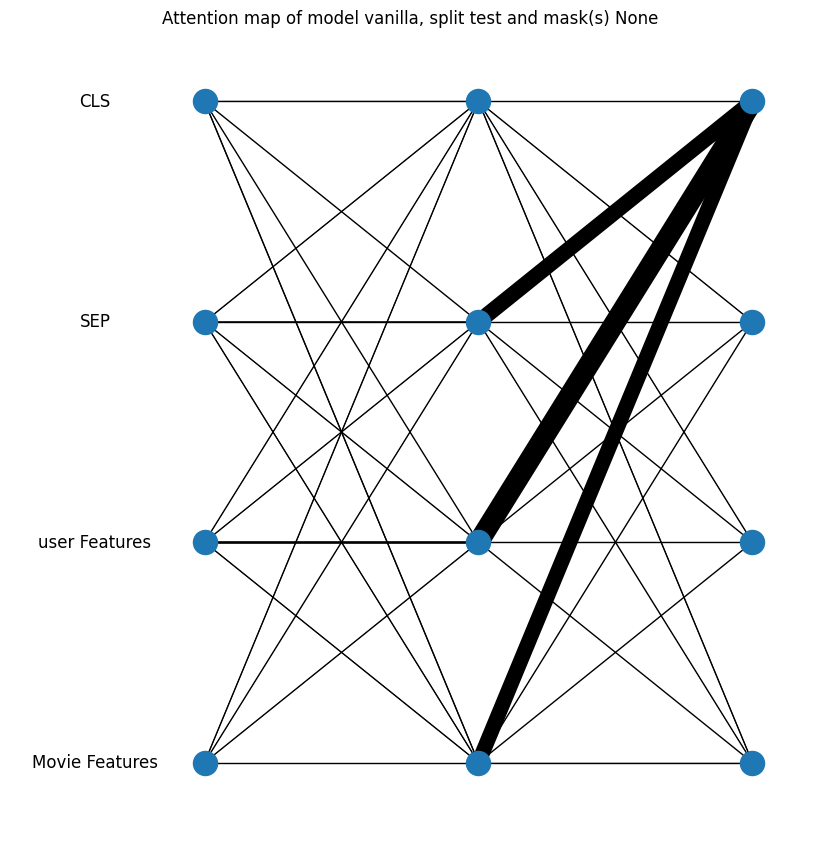

In [ ]:
exp.plot_attention_maps("test", [], "vanilla")

In [ ]:
import json
from typing import List, Tuple, Optional, Callable
import random as rd
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import networkx as nx
from sklearn.decomposition import PCA
import matplotlib.cm as cm
import joblib
from matplotlib.collections import PathCollection
import ast

from dataset_manager.kg_manager import ROOT
from llm_manager.vanilla.config import VANILLA_TOKEN_DICT
from llm_manager.graph_prompter_hf.config import (
    GRAPH_PROMPTER_TOKEN_DICT,
)


In [ ]:
subset_vanilla = subset = DatasetDict(
    {
        "train": dataset_vanilla["train"].select(range(5)),
        "test": dataset_vanilla["test"].select(range(5)),
        "val": dataset_vanilla["val"].select(range(5)),
    }
)
subset_prompt = subset = DatasetDict(
    {
        "train": dataset_prompt["train"].select(range(5)),
        "test": dataset_prompt["test"].select(range(5)),
        "val": dataset_prompt["val"].select(range(5)),
    }
)
subset_graph_prompter_hf = subset = DatasetDict(
    {
        "train": dataset_graph_prompter_hf["train"].select(range(5)),
        "test": dataset_graph_prompter_hf["test"].select(range(5)),
        "val": dataset_graph_prompter_hf["val"].select(range(5)),
    }
)

In [ ]:
(
    len(subset_vanilla["train"]["token_type_ranges"][0]),
    len(subset_prompt["train"]["token_type_ranges"][0]),
    len(subset_graph_prompter_hf["train"]["token_type_ranges"][0]),
)

(9, 13, 13)

In [ ]:
root_path = f"{ROOT}/llm"
dataset_path = "/dataset"
checkpoint = "/training/checkpoint-4420/trainer_state.json"
dataset_vanilla = load_from_disk(f"{root_path}/vanilla{dataset_path}")
dataset_prompt = load_from_disk(f"{root_path}/prompt{dataset_path}")
dataset_graph_prompter_hf = load_from_disk(
    f"{root_path}/graph_prompter_hf{dataset_path}"
)

c:\Users\MARS\.conda\envs\hauptprojekt\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


  0%|          | 0/67 [00:00<?, ?it/s]

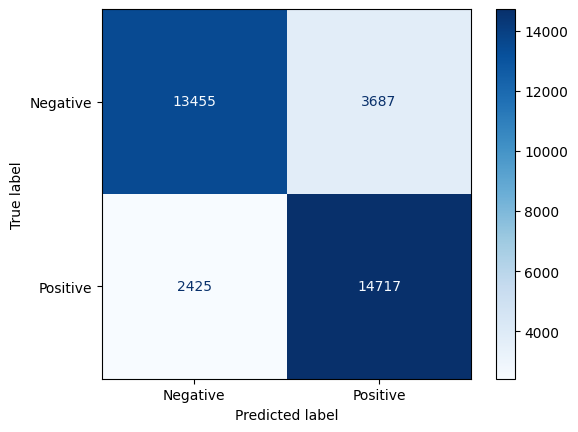

  0%|          | 0/67 [00:00<?, ?it/s]

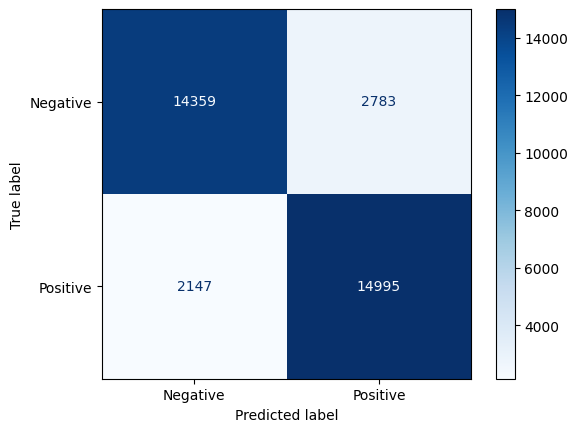

  0%|          | 0/67 [00:00<?, ?it/s]

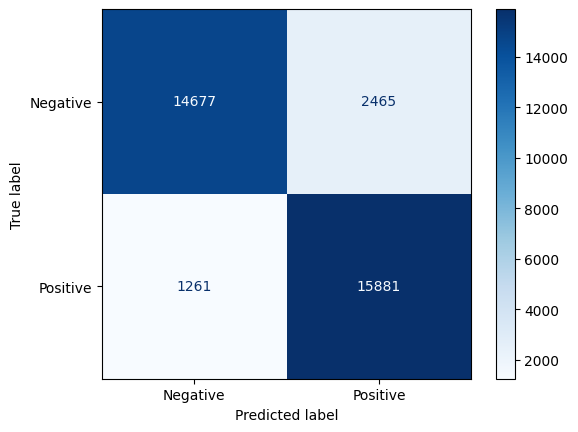

In [ ]:
ClassifierBase.plot_confusion_matrix(
    split="val", dataset=dataset_vanilla, batch_size=512
)
ClassifierBase.plot_confusion_matrix(
    split="val", dataset=dataset_prompt, batch_size=512
)
ClassifierBase.plot_confusion_matrix(
    split="val", dataset=dataset_graph_prompter_hf, batch_size=512
)
ClassifierBase.plot_confusion_matrix(
    split="val", dataset=dataset_graph_prompter_hf, batch_size=512
)